In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

# Plotting style
sns.set_theme(style="darkgrid")
%matplotlib inline

# Load your data
df = pd.read_csv('../data/processed/AAPL_stock_data_cleaned.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)


In [2]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Ensure 'Close' column is numeric (in case it was read as string)
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Drop missing values caused by conversion
df.dropna(subset=['Close'], inplace=True)

# Perform ADF test
result = adfuller(df['Close'])

# Print results
print("Augmented Dickey-Fuller Test Results")
print("-------------------------------------")
print(f"ADF Statistic      : {result[0]}")
print(f"p-value            : {result[1]}")
print(f"Num Lags Used      : {result[2]}")
print(f"Num Observations   : {result[3]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key} : {value}")


Augmented Dickey-Fuller Test Results
-------------------------------------
ADF Statistic      : 0.08300191489302557
p-value            : 0.9648812098675744
Num Lags Used      : 0
Num Observations   : 1759
Critical Values:
   1% : -3.4340730634421153
   5% : -2.8631845252929495
   10% : -2.5676454956964605


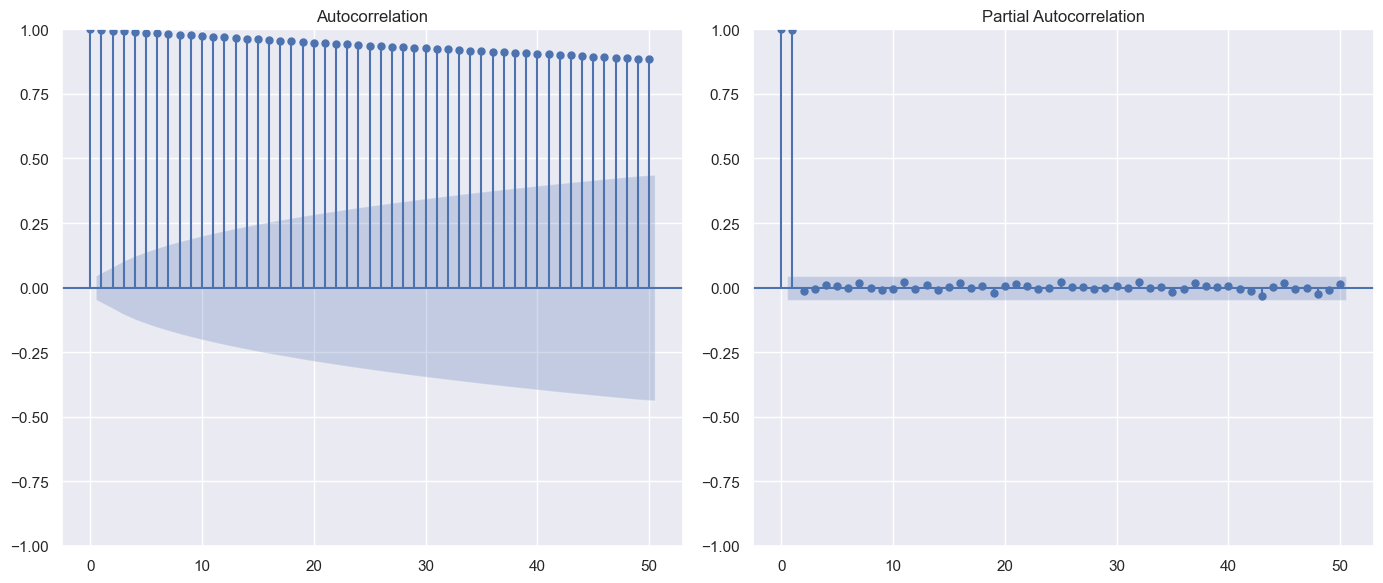

In [3]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(df['Close'].dropna(), ax=plt.gca(), lags=50)
plt.subplot(1, 2, 2)
plot_pacf(df['Close'].dropna(), ax=plt.gca(), lags=50, method='ywm')
plt.tight_layout()
plt.show()


In [4]:
# First difference to remove trend (make stationary)
df['Close_diff'] = df['Close'].diff()

# Drop NaNs created by differencing
df.dropna(subset=['Close_diff'], inplace=True)


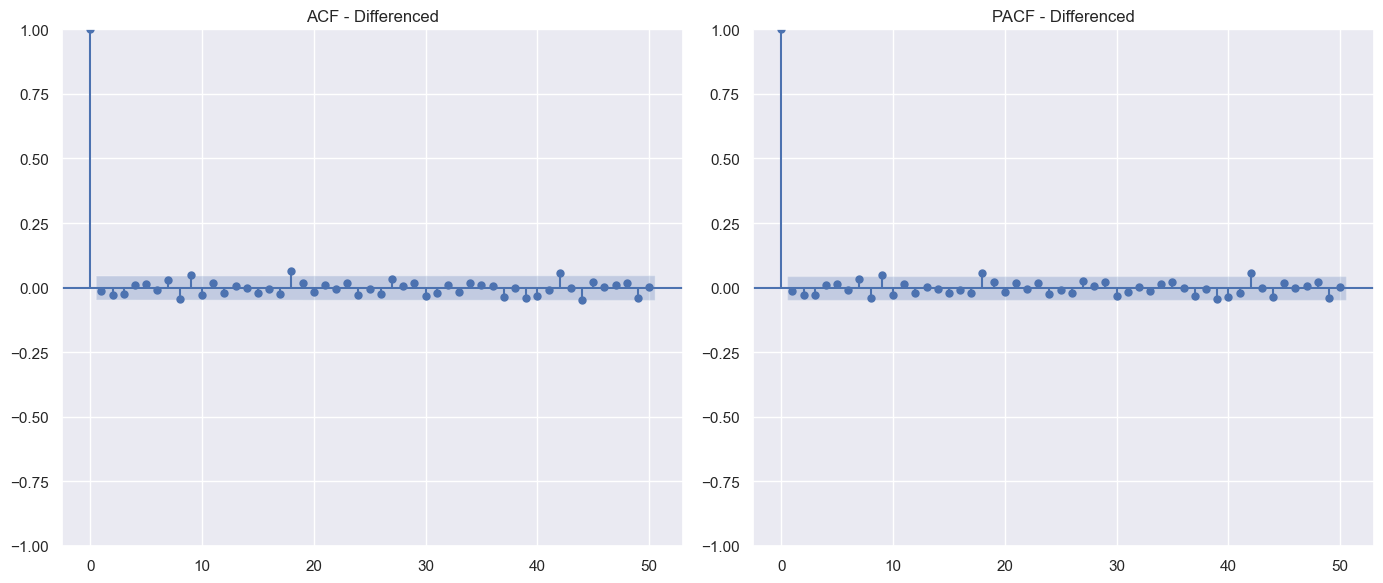

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plot_acf(df['Close_diff'], ax=plt.gca(), lags=50)
plt.title('ACF - Differenced')

plt.subplot(1, 2, 2)
plot_pacf(df['Close_diff'], ax=plt.gca(), lags=50, method='ywm')
plt.title('PACF - Differenced')
plt.tight_layout()
plt.show()


C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

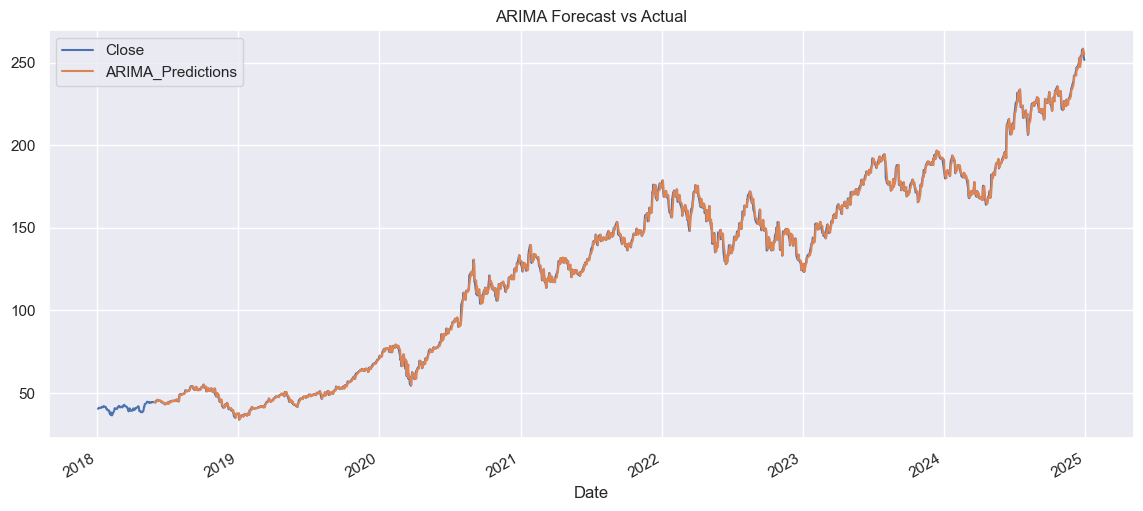

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Simple ARIMA model (adjust p,d,q based on ACF/PACF)
model = ARIMA(df['Close'], order=(5,1,2))
arima_result = model.fit()

# Plot predictions
df['ARIMA_Predictions'] = arima_result.predict(start=100, end=len(df)-1, typ='levels')

df[['Close', 'ARIMA_Predictions']].plot(figsize=(14, 6))
plt.title('ARIMA Forecast vs Actual')
plt.show()


C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Mayur\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary startin

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1759
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3950.231
Date:                Thu, 12 Jun 2025   AIC                           7906.462
Time:                        19:54:32   BIC                           7922.878
Sample:                             0   HQIC                          7912.529
                               - 1759                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5387      0.523      1.031      0.303      -0.485       1.563
ma.L1         -0.5595      0.517     -1.083      0.279      -1.572       0.453
sigma2         5.2390      0.108     48.464      0.0

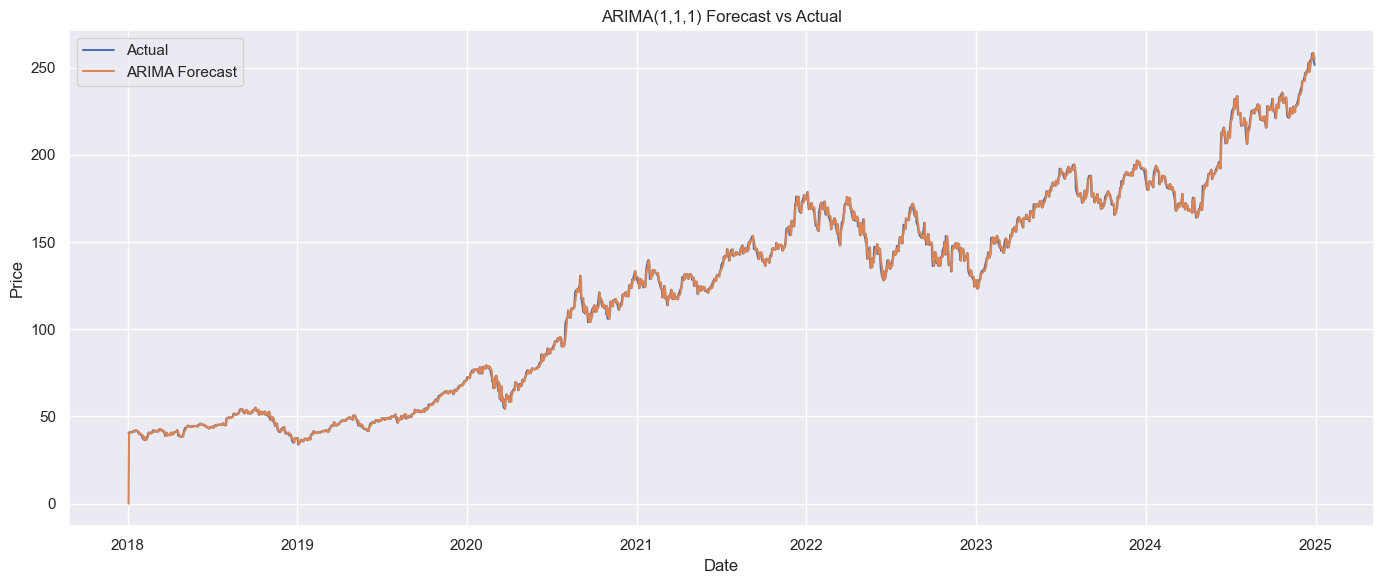

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model on original Close data (with differencing internally)
model = ARIMA(df['Close'], order=(1, 1, 1))
model_fit = model.fit()

# Print summary
print(model_fit.summary())

# Predict (in-sample forecast)
df['ARIMA_Forecast'] = model_fit.predict(start=0, end=len(df)-1, typ='levels')

# Plot actual vs forecast
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Actual')
plt.plot(df['ARIMA_Forecast'], label='ARIMA Forecast')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


19:54:38 - cmdstanpy - INFO - Chain [1] start processing
19:54:39 - cmdstanpy - INFO - Chain [1] done processing


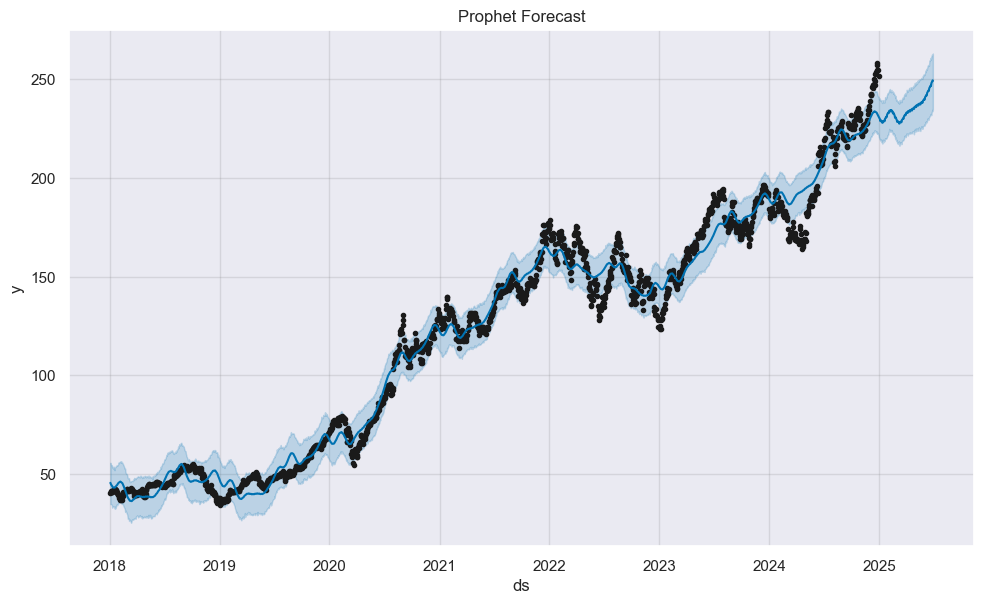

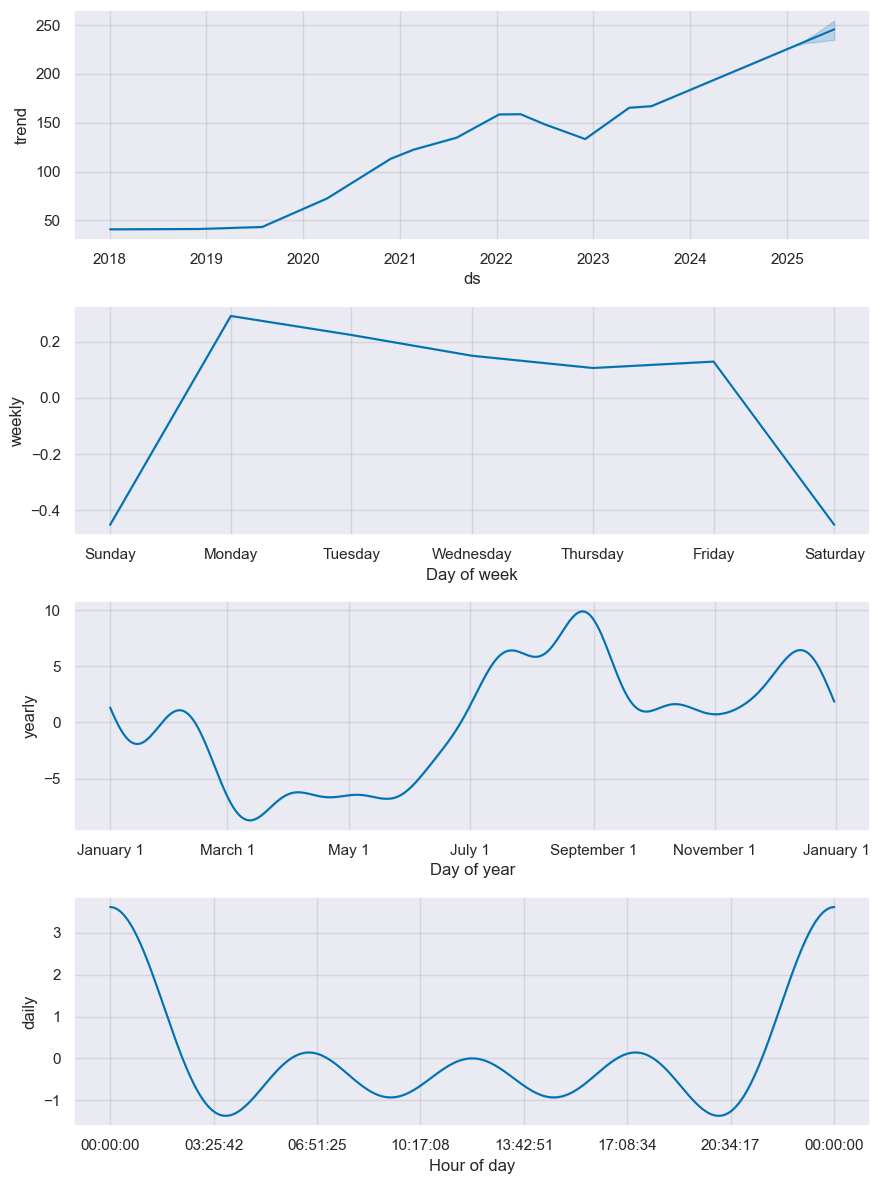

In [8]:
# Prepare data for Prophet
prophet_df = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize and fit model
prophet = Prophet(daily_seasonality=True)
prophet.fit(prophet_df)

# Make future dataframe (e.g., 180 days into the future)
future = prophet.make_future_dataframe(periods=180)
forecast = prophet.predict(future)

# Plot forecast
fig1 = prophet.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# Plot forecast components
fig2 = prophet.plot_components(forecast)
plt.show()


In [9]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('../data/processed/prophet_forecast.csv', index=False)


In [10]:
# ARIMA Prediction
df['ARIMA_Pred'] = arima_result.predict(start=1, end=len(df)-1, typ='levels')


In [11]:
# Match only the forecast rows that align with the original df
df['Prophet_Pred'] = forecast.loc[forecast['ds'] <= df.index[-1], 'yhat'].values


In [12]:
df_eval = df.dropna(subset=['ARIMA_Pred', 'Prophet_Pred'])


In [13]:
# Drop initial NaNs for fair comparison
df_eval = df.dropna(subset=['ARIMA_Pred', 'Prophet_Pred'])

# Define metrics
def evaluate(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

# Evaluate ARIMA
arima_rmse, arima_mae, arima_mape = evaluate(df_eval['Close'], df_eval['ARIMA_Pred'])

# Evaluate Prophet
prophet_rmse, prophet_mae, prophet_mape = evaluate(df_eval['Close'], df_eval['Prophet_Pred'])

# Print
print("🔢 ARIMA Model Performance:")
print(f"RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}, MAPE: {arima_mape:.2f}%\n")

print("🔮 Prophet Model Performance:")
print(f"RMSE: {prophet_rmse:.2f}, MAE: {prophet_mae:.2f}, MAPE: {prophet_mape:.2f}%")


🔢 ARIMA Model Performance:
RMSE: 2.28, MAE: 1.57, MAPE: 1.36%

🔮 Prophet Model Performance:
RMSE: 7.91, MAE: 6.16, MAPE: 6.26%


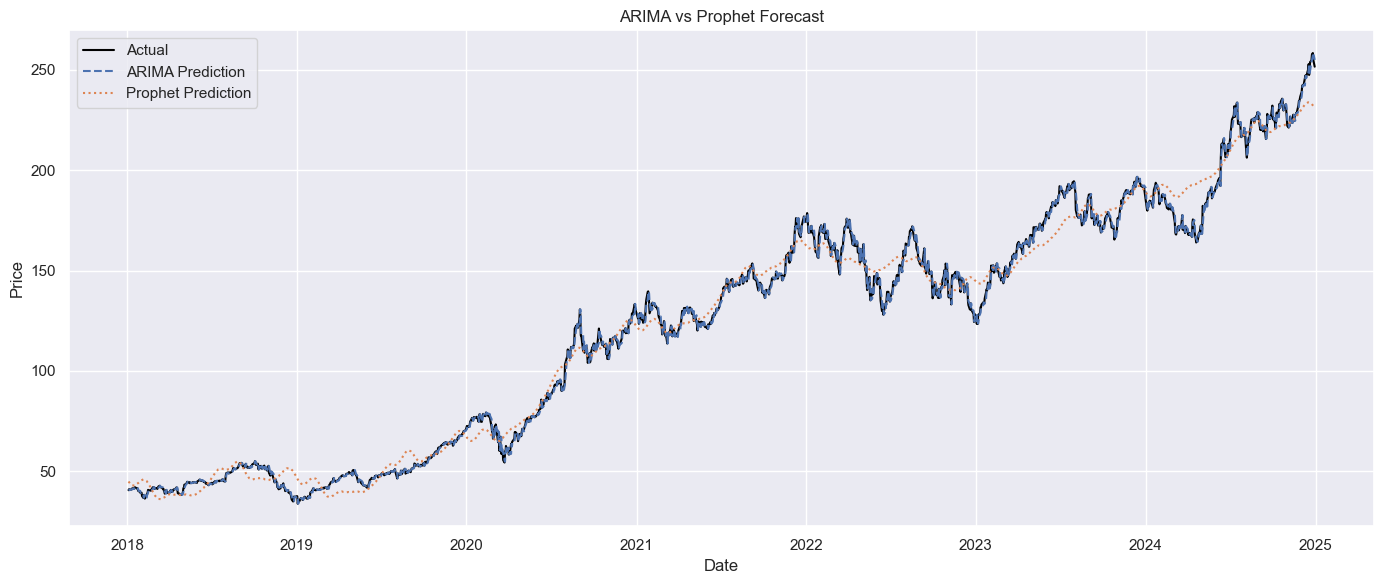

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(df_eval['Close'], label='Actual', color='black')
plt.plot(df_eval['ARIMA_Pred'], label='ARIMA Prediction', linestyle='--')
plt.plot(df_eval['Prophet_Pred'], label='Prophet Prediction', linestyle=':')
plt.title('ARIMA vs Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
